In [16]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Dropout,Input,BatchNormalization
from keras.models import Model,load_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,Conv1D,MaxPooling1D
from tensorflow.python.keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import keras
from keras import regularizers


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cd drive

In [2]:
dataset_dir = "alzheimer_new_1/alzheimer_new/ADNI_DATASET"

In [3]:
# Parameters
input_shape = (224, 224, 3)
num_classes = 3
batch_size = 32
epochs = 200


In [44]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    #shear_range=0.2,
    
    validation_split=0.3
)


In [45]:
# Define train and validation generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3608 images belonging to 3 classes.
Found 1546 images belonging to 3 classes.


In [46]:
train_generator.classes
y_train=keras.utils.to_categorical(train_generator.classes)
y_train.shape


(3608, 3)

In [47]:
num_train_classes = train_generator.num_classes

# Number of validation classes
num_validation_classes = validation_generator.num_classes

print("Number of training classes:", num_train_classes)
print("Number of validation classes:", num_validation_classes)

Number of training classes: 3
Number of validation classes: 3


In [8]:
# Get the mapping of class indices to class names
class_indices = train_generator.class_indices

# Invert the mapping to get class names to class indices
class_names = {v: k for k, v in class_indices.items()}

# Initialize dictionaries to store the counts
train_class_counts = {class_name: 0 for class_name in class_names.values()}
validation_class_counts = {class_name: 0 for class_name in class_names.values()}

# Count the number of images in each class for the training set
for filename in train_generator.filenames:
    class_name = os.path.dirname(filename)
    train_class_counts[class_name] += 1

# Count the number of images in each class for the validation set
for filename in validation_generator.filenames:
    class_name = os.path.dirname(filename)
    validation_class_counts[class_name] += 1

print("Number of images in each class in the training set:")
print(train_class_counts)

print("\nNumber of images in each class in the validation set:")
print(validation_class_counts)


Number of images in each class in the training set:
{'AD': 900, 'CN': 1152, 'MCI': 2072}

Number of images in each class in the validation set:
{'AD': 224, 'CN': 288, 'MCI': 518}


In [48]:
# Load pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Load pre-trained ResNet50 model
# resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Load pre-trained inception model
# inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)


In [49]:
# Freeze convolutional layers
for layer in vgg_base.layers:
     layer.trainable = False


In [50]:
vgg_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Output_VGG_Layer

In [151]:
output_vgg_layer=vgg_base.get_layer("block5_pool")
output_vgg=output_vgg_layer.output
features_vgg=Flatten()(output_vgg)
model=Model(inputs=vgg_base.input,outputs=features_vgg)
#plot_model(model, show_shapes = True, show_layer_names = True, to_file = 'feature_extract.png')
#model.compile(optimizer=Adam)



In [17]:
#model=load_model('best_model (1).h')

ValueError: File format not supported: filepath=best_model (1).h. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(best_model (1).h, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
!ls


drive  sample_data


In [152]:
train_features=model.predict(train_generator)


C:\Users\Adya2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


129/129 ━━━━━━━━━━━━━━━━━━━━ 623s 5s/step


In [155]:
validation_features = model.predict(validation_generator)

# Evaluate the model using PCA-transformed validation features and labels


33/33 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step


In [156]:
np.save("test_features_noaugment.npy",validation_features)

In [154]:
import numpy as np
np.save("train_features_noaugment.npy",train_features)

In [159]:
train_features.shape

(4124, 25088)

# **PCA**

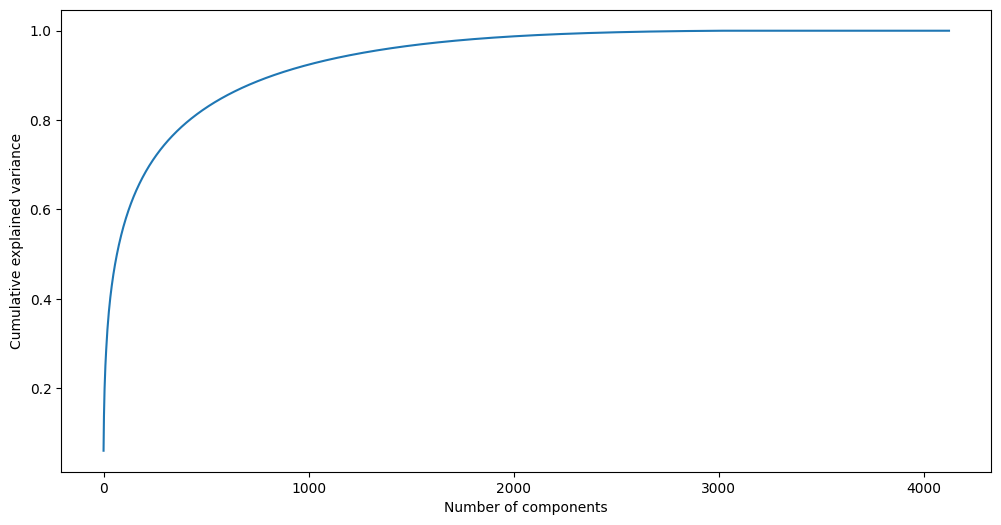

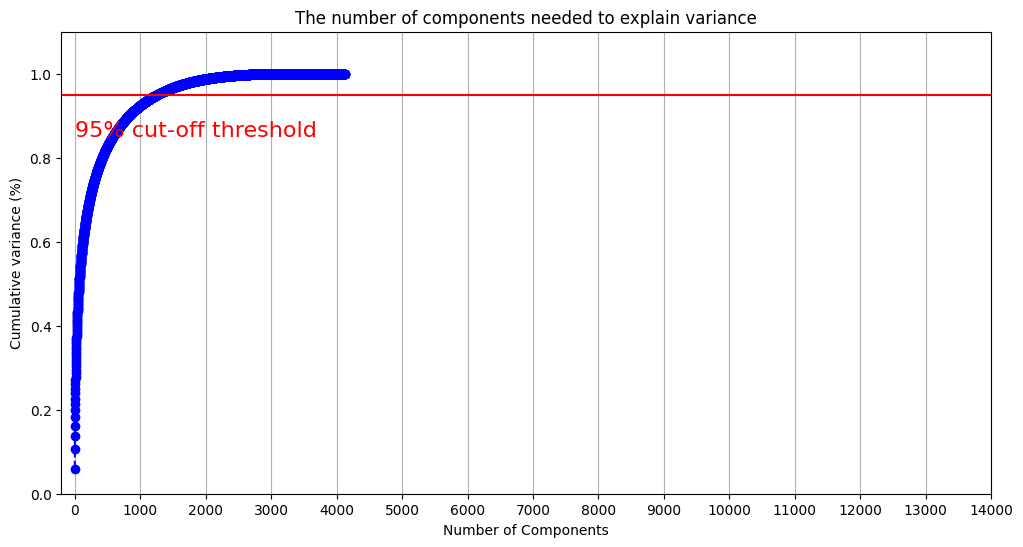

In [160]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
train_features=np.load("train_features_noaugment.npy")
scaler = StandardScaler()
X_sc_train = scaler.fit_transform(train_features)

pca = PCA()#add n_components=the feature at 95%
pca.fit(X_sc_train)
features_pca_train = pca.fit_transform(X_sc_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')



plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 4125, step = 1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 15000, step = 1000)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
ax.grid(axis='x')
plt.show()

In [126]:
n_components = 1200
pca=PCA(n_components)
features_pca_train = pca.fit_transform(X_sc_train)
np.save('features_pca_train_normalized.npy', features_pca_train)


In [51]:
features_pca_train=np.load('features_pca_train_normalized.npy')

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
validation_features=np.load("test_features_noaugment.npy")
scaler=StandardScaler()
pca=PCA(1200)
X_sc_validation = scaler.transform(validation_features)
features_pca_validation = pca.fit(X_sc_validation)
np.save('features_pca_validation.npy',features_pca_validation)
y_test = keras.utils.to_categorical(validation_generator.classes)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [40]:
X_sc_validation.shape

(1030, 25088)

In [ ]:
# Add custom classification layers
# x = Flatten()(inception_base.output)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# predictions = Dense(num_classes, activation='softmax')(x)

In [129]:
# # Create the model
#model = Model(inputs=vgg_base.input, outputs=predictions)

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])


In [28]:
#var_name=np.load(filevalue)
input=Input(shape=(1200,))
x=BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(input)
x=Dense(256,kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006),activation='relu')(x)
x=Dropout(rate=0.3,seed=42)(x)
x=Dense(64,kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006),activation='relu')(x)
x=Dropout(rate=0.3,seed=42)(x)
x=Dense(3,kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006),activation='softmax')(x)
model=Model(inputs=input,outputs=x)

# Compile the model with adjusted hyperparameters
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy',metrics=['accuracy','recall'])
# Adjust the learning rate as needed

In [30]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    save_best_only=True,
    monitor='accuracy',
    mode='max'
)

learning_rate_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='accuracy',
    patience=3,
    factor=0.5,verbose=1
)

In [31]:
model.fit(features_pca_train, y_train, epochs=200, batch_size=32, callbacks = [checkpoint_callback,learning_rate_scheduler_callback])

Epoch 1/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2809 - loss: 39.0908 - recall: 0.2088 - learning_rate: 1.0000e-04
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3328 - loss: 31.7118 - recall: 0.1214 - learning_rate: 1.0000e-04
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3294 - loss: 26.9923 - recall: 0.0437 - learning_rate: 1.0000e-04
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3879 - loss: 21.9238 - recall: 0.0193 - learning_rate: 1.0000e-04
Epoch 5/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3952 - loss: 16.5381 - recall: 0.0097 - learning_rate: 1.0000e-04
Epoch 6/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4226 - loss: 12.3060 - recall: 0.0031 - learning_rate: 1.0000e-04
Epoch 7/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4569 - loss: 9.6416 - recall: 2.1698e-04 - learning_rate: 1.0000e-04
Epoch 8/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0

In [33]:
features_pca_train.shape

(4124, 1200)

In [136]:
#model.fit(features_pca_train,y_train,epochs=200,batch_size=32)

Epoch 1/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.3316 - loss: 2.3789 - recall: 0.2930
Epoch 2/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3541 - loss: 1.2631 - recall: 0.1814
Epoch 3/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3418 - loss: 1.1646 - recall: 0.0820
Epoch 4/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3424 - loss: 1.1260 - recall: 0.0432
Epoch 5/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3598 - loss: 1.1150 - recall: 0.0294
Epoch 6/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3498 - loss: 1.1048 - recall: 0.0209
Epoch 7/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3550 - loss: 1.1016 - recall: 0.0148
Epoch 8/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3518 - loss: 1.0997 - recall: 0.0128
Epoch 9/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3585 - loss: 1.0984 - recall: 0.0170
Epoch 10/200
380/380 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy

In [34]:
# Print model summary for debugging
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1200)           │         4,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       307,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 981,899 (3.75 MB)

 Trainable params: 326,499 (1.25 MB)

 Non-trainable params: 2,400 (9.38 KB)

 Optimizer params: 653,000 (2.49 MB)

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict classes for the validation set
validation_predictions = model.predict(features_pca_validation)

# Convert probabilities to class labels
predicted_classes = np.argmax(validation_predictions, axis=1)

# Get true class labels
true_classes = validation_generator.classes

# Calculate precision
precision = precision_score(true_classes, predicted_classes, average='weighted')

# Calculate recall
recall = recall_score(true_classes, predicted_classes, average='weighted')

# Calculate F1 score
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 1200), found shape=(32, 1030)

The _new file as of now has the model and precision and recall for the images with noise and blur
Save it into a new file if making any changes so that the model can be evaluated easily